# Instacart Market Basket Analysis

Instacart에서 제공하는 dataset은 익명화된 20만 이상의 유저로부터 340만 이상의 주문이 포함되어 있습니다.

목표:
타겟은 어떤 제품이 유저의 다음 구매에 들어갈지 예측하는 것 입니다.


# 1. 데이터 살펴보기



제공되는 데이터셋은 총 7개의 csv파일로 이루어져 있습니다.

1. orders.csv (3421083, 7) <br/>
unique한 주문 id에 별로 정보가 있습니다.

    <img src=https://user-images.githubusercontent.com/89520805/167748653-3dd79f32-443f-49b1-a293-e2ec36f4849f.png width=700 height=150>

2. order_products__priors.csv (32434489, 4) <br/>
고객별로 마지막 주문을 제외한 모든 주문에 대한 구매내역입니다.
각 행의 order_id와 product_id를 하나의 조합이라고 볼 수 있습니다.

    <img src=https://user-images.githubusercontent.com/89520805/167748919-dc42cbe8-eb55-44b0-b4c5-0f088c1a19b3.png width=400 height=150>

3. order_products__train.csv (1384617, 4) <br/>
일부 고객의 마지막 주문 구매내역 입니다.구매예측을 위해서 해당 데이터를 가지고 타겟을 생성해야 합니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749067-652a45e7-658c-4a28-ac6c-e08fd601afe0.png width=400 height=150>

4. products.csv (49688, 4)<br/>
등록된 제품 id를 기준으로 제품에 대한 4개 정보가 들어있습니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749255-52f05c2e-fa84-472b-9195-eca80b5eb3f1.png width=600 height=150>

5. aisles.csv (134, 2) <br/>
제품을 소 분류로 분류한 정보입니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749643-b11ce7b9-e765-4f42-9da3-33491b014172.png width=280 height=150>

6. departments.csv (21, 2)<br/>
제품을 대 분류로 분류한 정보입니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749715-9a5717d3-6739-4a3f-9a79-9067a1326ada.png width=250 height=150>

7. sample_submission.csv (75000, 2)<br/>
제출해야하는 형식 파일입니다. orders['eval_set'] == test 인 order_id이다.

    <img src=https://user-images.githubusercontent.com/89520805/167749883-9b0caa6b-24a0-4396-bca8-e0d6a6e3b270.png width=190 height=150>

# Issues 

1. 메모리 관리

    - 피쳐별 데이터 타입 변환 함수 사용
    - 사용하지 않는 변수는 삭제

2. 피쳐 생성

    - 먼저 groupby가 가능한 피쳐들을 생성. 이후에 판단 필요

3. 데이터 재가공

    - 대회 목적에 맞는 예측을 하기 위한 훈련이 가능한 형태로 데이터를 재가공


- 참고 코드

    - https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart
    - https://www.kaggle.com/code/paulantoine/light-gbm-benchmark-0-3692



# 데이터 로드

## 기본 파일

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

In [ ]:
priors = pd.read_csv(PATH + 'order_products__prior.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1
orders = pd.read_csv(PATH + 'orders.csv', dtype={
        'order_id': np.uint32,              # 1 ~ 3421083
        'user_id': np.uint32,               # 1 ~ 206209
        'eval_set': 'category',             # 3가지
        'order_number': np.uint8,           # 1 ~ 100
        'order_dow': np.uint8,              # 0 ~ 6 
        'order_hour_of_day': np.uint8,      # 0 ~ 23
        'days_since_prior_order': np.float32})
products = pd.read_csv(PATH + 'products.csv', dtype={
        'product_id': np.uint16,     # 1 ~ 49688
        'aisle_id': np.uint8,        # 1 ~ 134
        'department_id': np.uint8}) # 1 ~ 21

In [ ]:
aisles = pd.read_csv(PATH + 'aisles.csv', dtype={
        'product_id': np.uint16})     # 1 ~ 49688
departments = pd.read_csv(PATH + 'departments.csv', dtype={
        'product_id': np.uint16})
train = pd.read_csv(PATH + 'order_products__train.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1

## 1. 데이터 하나로 합치기

EDA를 위해서 모든 csv파일을 병합해서 하나로 사용

In [ ]:
df = priors.append(train)
df = df.merge(products, on='product_id', how='left')
df = df.merge(aisles, on='aisle_id', how='left')
df = df.merge(departments, on='department_id', how='left')
df = df.merge(orders, on='order_id', how='outer')
df = df.astype({'product_id': np.float32, 'add_to_cart_order': np.float32, 'reordered': np.float32, 
                'aisle_id': np.float32,'department_id':np.float32, 'product_name' : 'category', 
                'aisle' : 'category', 'department' : 'category'})
col = ['user_id', 'order_number', 'order_id', 'product_id', 'product_name', 'add_to_cart_order', 'reordered', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'aisle_id', 'aisle', 'department_id', 'department', 'eval_set']
df = df[col]
df.sort_values(by=['user_id', 'order_number'], inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33894106 entries, 0 to 33894105
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   user_id                 uint32  
 1   order_number            uint8   
 2   order_id                uint32  
 3   product_id              float32 
 4   product_name            category
 5   add_to_cart_order       float32 
 6   reordered               float32 
 7   order_dow               uint8   
 8   order_hour_of_day       uint8   
 9   days_since_prior_order  float32 
 10  aisle_id                float32 
 11  aisle                   category
 12  department_id           float32 
 13  department              category
 14  eval_set                category
dtypes: category(4), float32(6), uint32(2), uint8(3)
memory usage: 1.4 GB


In [ ]:
df.isnull().sum()

user_id                         0
order_number                    0
order_id                        0
product_id                  75000
product_name                75000
add_to_cart_order           75000
reordered                   75000
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
aisle_id                    75000
aisle                       75000
department_id               75000
department                  75000
eval_set                        0
dtype: int64

하나로 합친 df 저장

In [ ]:
df.to_pickle(PATH + 'EDA.pkl')

## ✅ 2. 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.2)
%matplotlib inline
color = sns.color_palette()

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_pickle(PATH + 'EDA.pkl')

##  ✅ df 결측치 확인  

In [ ]:
df.isnull().sum()

user_id                         0
order_number                    0
order_id                        0
product_id                  75000
product_name                75000
add_to_cart_order           75000
reordered                   75000
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
aisle_id                    75000
aisle                       75000
department_id               75000
department                  75000
eval_set                        0
dtype: int64

In [ ]:
data = df[(df.order_number != 1) & (df.eval_set == 'prior')].groupby('product_name')['reordered'].max().reset_index()
data[data.reordered == 0]

,product_name,reordered
2,#2 Mechanical Pencils,0.0
5,'Swingtop' Premium Lager,0.0
8,".5\"" Waterproof Tape",0.0
27,007 Vodka With Martini Glasses,0.0
43,1% Hydrocortisone Anti-Itch Liquid Maximum Str...,0.0
...,...,...
49603,Ziti Rigate Penne,0.0
49619,Zyflamend Whole Body,0.0
49620,Zyflamend Whole Body Liquid Vcaps,0.0
49636,"flings! Laundry Detergent Pacs, Original, 57 C...",0.0


결측치 처리에 대한 고민
1. orders의 days_since_prior_order 컬럼에 존재하는 결측치
  * 결측치(고객의 첫 주문)를 다 날려야한다는 주장과 그 이유
    1. 해당 데이터의 양이 전체 데이터(3,421,083)건 중 6.03%만 차지함. row 삭제로 클랜징이 가능한 범위임
    2. 결측치의 종류가 고객의 첫 주문만(1번째 order_id) 해당됨. 이는 타겟값인 재구매는 이전에 구매한 내용이 있으면 1로 표기되기 때문에 전부 0으로 표기되는 첫 주문 데이터는 날려도 재구매 여부 판단에는 큰 영향을 끼치지 않는다고 판단됨
    3. 결측치를 삭제하지 않는다면 임의의 값으로 채워야하는데, days_since_prior_order 컬럼의 값 분포를 봤을 때 20만건의 데이터가 임의의 값으로 포함되면 데이터에 큰 영향을 주게 됨
  * 반대 의견 
    1. days_since_prior_order의 결측치는 EDA 진행시에는 결측치로 남겨둬도 상관없다. 첫 번째 주문을 날린다는 뜻은 첫번째 주문에 포함된 제품 정보까지 날린다는 얘기로 그렇게 되면 데이터에 미치는 영향이 너무 크다.  이전 주문이 없어서 결측치인 건데 결측치라는 이유로 첫번째 주문을 날리면 이번에는 두번째 주문이 첫번째 주문이 되면서 결측치가 생길 것이다. 

2. train을 포함한 데이터를 하나로 합치면서 포함된 train의 결측치

# Orders

모든 주문 정보를 확인할 수 있다.

총 3,421,083개의 row가 있다. 이 데이터의 모든 주문 수

- order_id : 주문 번호

    총 3,421,083개의 주문이 있다.

- user_id : 고객 번호

    총 206,209명의 데이터

- eval_set : 데이터 구분

    prior, train, test로 구분. 

    - prior : 고객별 마지막 주문을 제외한 모든 주문

    - train : 131,209명의 마지막 주문. 주문별 구매 내역이 있다.

    - test : 75,000명의 마지막 주문. 주문별 구매 내역을 예측해야 한다.

- order_number : 해당 고객의 몇 번째 주문인지, (범주형, 순서형)

    최소 주문 수는 4건, 최대 주문 수는 100건이다. 

- order_dow : 주문 요일

- order_hour_of_day : 주문 시간 

- days_since_prior_order : 이전 주문과의 간격 (일). 최대 30일이다. 

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## 결측치 확인

In [ ]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

days_since_prior_order에 206,209 건의 결측치가 있다. 첫번째 주문은 이전 주문이 없기 때문에 모든 고객의 수만큼 결측치가 있다.

## order_id

주문 번호

In [ ]:
print(f"총 주문 수 : {orders.order_id.nunique()}")

총 주문 수 : 3421083


## user_id

고객 번호

In [ ]:
print(f"총 고객 수 : {orders.user_id.nunique()}")

총 고객 수 : 206209


## eval_set

데이터 구분

prior, train, test로 구분.

- prior : 고객별 마지막 주문을 제외한 모든 주문

- train : 131,209명의 마지막 주문. 주문별 구매 내역이 있다.

- test : 75,000명의 마지막 주문. 주문별 구매 내역을 예측해야 한다.

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


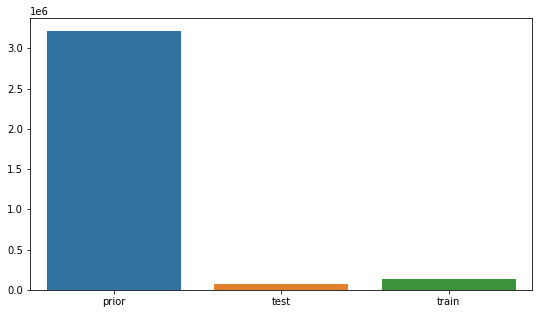

In [ ]:
data = orders.eval_set.value_counts()
print(data)
plt.figure(figsize=(9, 5))
sns.barplot(x=data.index, y=data.values)
plt.show()

## order_number

해당 고객의 몇 번째 주문인지 알 수 있다. 

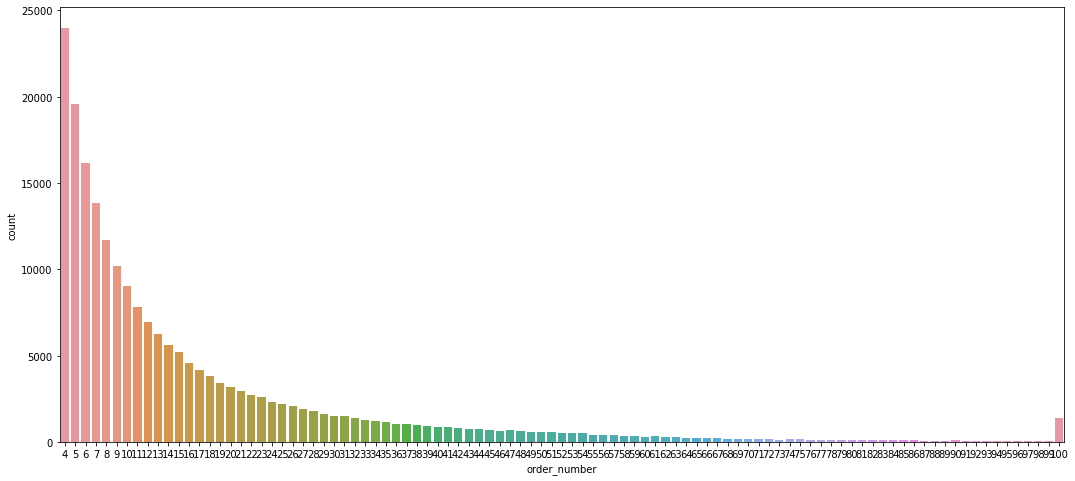

In [ ]:
plt.figure(figsize=(18, 8))
data = orders.groupby('user_id')['order_number'].max().reset_index()
sns.countplot(x='order_number', data=data)
plt.show()

In [ ]:
orders.groupby('user_id')['order_number'].max().describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64

최소 주문 수는 4건, 최대 주문 수는 100건이다. 고객 평균 주문 수는 16건, 중앙값은 10이다.

4회 주문한 고객이 가장 많다.

## order_dow

주문 요일

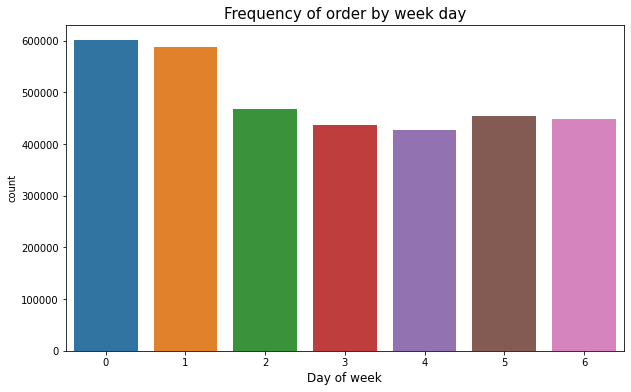

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_dow', data=orders)
plt.title("Frequency of order by week day", fontsize=15)
plt.xlabel('Day of week', fontsize=12)
plt.show()

In [ ]:
round(orders.order_dow.value_counts()[:2].mean() / orders.order_dow.value_counts()[2:].mean(), 2)

1.33

0은 토요일, 1은 일요일이다. 주말이 평일에 비해서 주문 수가 약 33%가 많다.

## order_hour_of_day

주문 시간

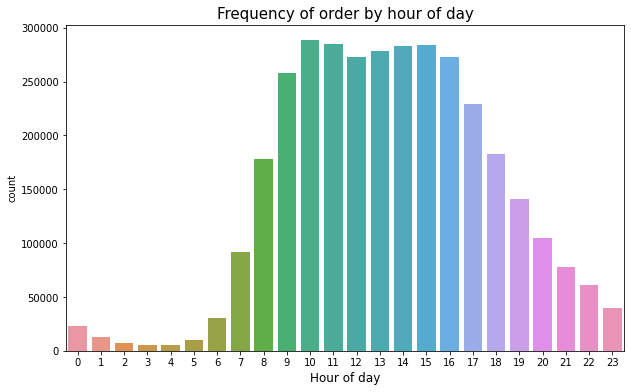

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_hour_of_day', data=orders)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.xlabel('Hour of day', fontsize=12)
plt.show()

대부분의 고객들은 9~17시 사이에 주문하는 것을 볼 수 있다.


### 요일 x 시간

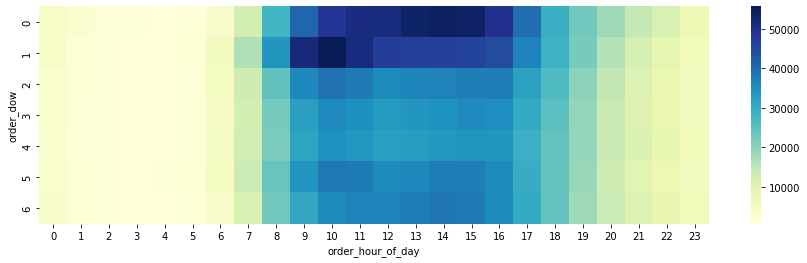

In [ ]:
plt.figure(figsize=(15, 4))
data = orders.groupby(['order_dow', 'order_hour_of_day'])['order_number'].count().reset_index().pivot('order_dow','order_hour_of_day','order_number')
sns.heatmap(data, cmap="YlGnBu")
plt.show()

평일에 비하면 주말이 확연히 주문량이 많은 것을 볼 수 있다. 토요일은 오후, 일요일은 오전에 주문이 가장 많은 것을 확인할 수 있다.
토요일은 모든 요일 중에서 가장 늦은 시간까지 주문이 일어난다. 
평일을 보면 화요일과 수요일이 비교적 주문이 적은 것을 볼 수 있다.


### ✅ Weekly-Hour

요일과 시간이 유저의 구매에 미치는 영향 확인

In [ ]:
index2day = "Sat Sun Mon Tue Wed Thu Fri".split()

In [ ]:
def drawWeekHour(ds, values,  aggfunc=len, title=None, figsize=(18,5) , cmap=None):
    weekhour_ds = ds.pivot_table(index='order_dow', columns='order_hour_of_day', values=values, aggfunc=aggfunc).fillna(0)
    weekhour_ds.index =  [  index2day[index] for index in weekhour_ds.index]
    sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )

    plt.figure(figsize=figsize)
    f = sns.heatmap(weekhour_ds, annot=True, fmt="1.1f", linewidths=.5, cmap=cmap) 
    plt.xlabel("Hour")
    plt.ylabel("Day of Week")
    if title:
        plt.title(title, fontsize=15)

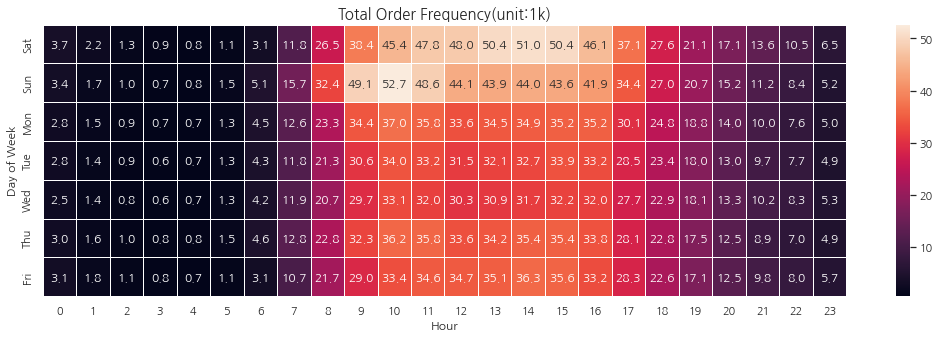

In [ ]:
drawWeekHour(orders, values='order_id', title="Total Order Frequency(unit:1k)", aggfunc=lambda x: len(x)/1000)

앞서 확인했던것처럼 주말(0~1)과 09~17시 사이에 주문이 많은 것을 볼 수 있다.
* 이 주문들은 주문하는 고객이 많은 건지? 고객 당 주문 건수가 많은 건지?

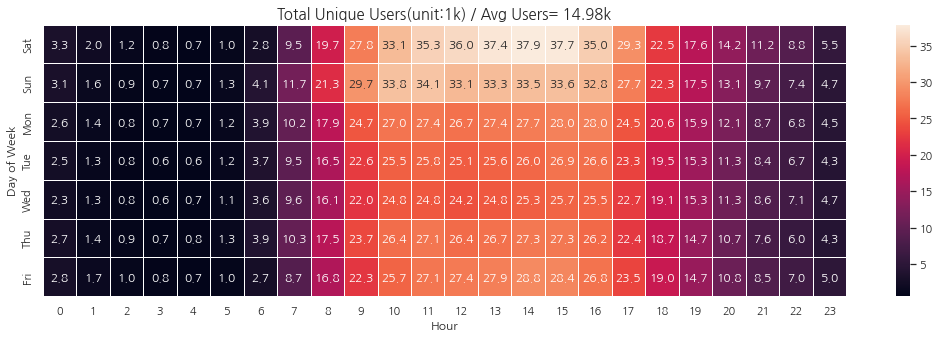

In [ ]:
# 요일-시간대 별 발생한 주문 건수 중 unique한 user 확인

avg_users = round(orders.groupby(['order_dow','order_hour_of_day']).agg({'user_id':lambda x: len(x.unique())/1000}).mean().values[0],2)
drawWeekHour(orders, values='user_id', title="Total Unique Users(unit:1k) / Avg Users= {}k".format(avg_users), aggfunc=lambda x: len(x.unique())/1000)

전체 주문건수와 유사한 것이 확인된다.

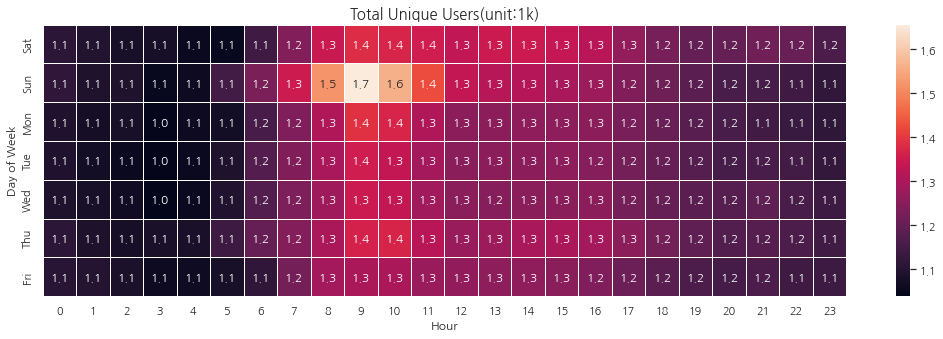

In [ ]:
# 요일-시간대 별 발생한 주문 중 user_id당 몇 건의 주문이 발생했는지 확인

drawWeekHour(orders, values='user_id', title='Total Unique Users(unit:1k)', aggfunc=lambda x: len(x)/len(x.unique()))

1번 요일(일요일 추정)의 8-10h 때 많은 주문 건수가 발생하는 게 확인된다.
    * 한 사람이 1회 이상의 order를 넣을 이유는 무엇일까?
    * 주말에 장을 본 후 누락한 물건들을 추가로 장을 보는 것인지?
    * instacart에는 정기배송(정기구매) 시스템이 있어 해당 요일에 자동으로, 별도의 order_id로 결제가 진행되는 건지?

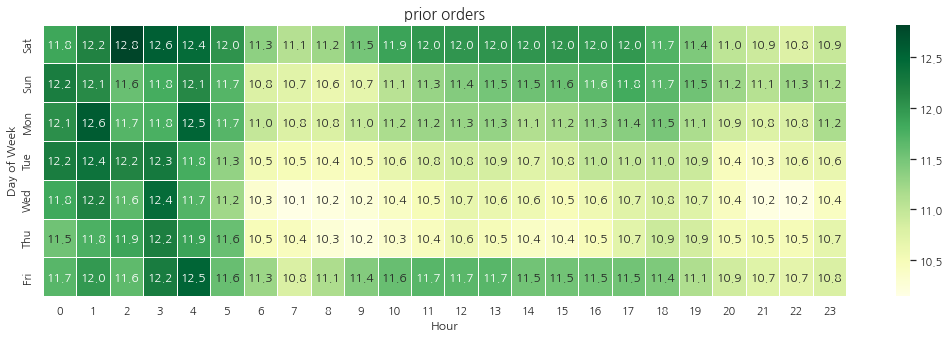

In [ ]:
# 요일-시간대 별 발생한 주문들의 재구매까지 걸리는 평균 일수

drawWeekHour(orders, values='days_since_prior_order', title="prior orders", aggfunc=lambda x: np.mean(x), cmap='YlGn')

`days_since_prior_order`의 경우 7일과 30일 주기가 가장 많았고, 14, 21, 28등 7일 주기가 그 다음으로 많았다.  
이를 비춰봤을 때 `days_since_prior_order`의 요일-시간대 별 전체 평균은 유의미한 패턴 확인이 어려울 것으로 보인다.
* 7일 이하 / 8~29일 / 30일로 나눠서 확인해본다면 차이가 있을까?

금요일과 토요일, 0~6시 새벽시간 대에 발생한 주문이 다음 주문까지 기간이 길게 나타남
* 새벽 2~6시 등 일반적으로 장을 보지않는 시간대라서 재주문 텀이 길게 나타나는 게 아닌지?

In [ ]:
a = priors.groupby('order_id')['product_id'].count().reset_index().rename(columns={'order_id':'order_id','product_id' : 'items'})
orders = orders.merge(a, on='order_id', how='left')

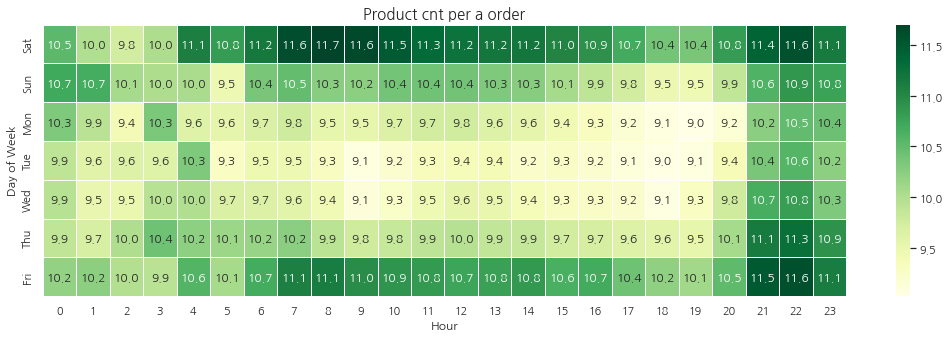

In [ ]:
# 요일-시간대 별 발생한 주문들의 평균 구매제품 수
drawWeekHour(orders, values='items', title="Product cnt per a order", aggfunc=lambda x: np.mean(x), cmap='YlGn')

금요일과 토요일에 발생한 주문의 상품 주문 개수가 많음  
오전 7-8h와 오후 21-23h에 주문 개수가 많음
* 

## days_since_prior_order

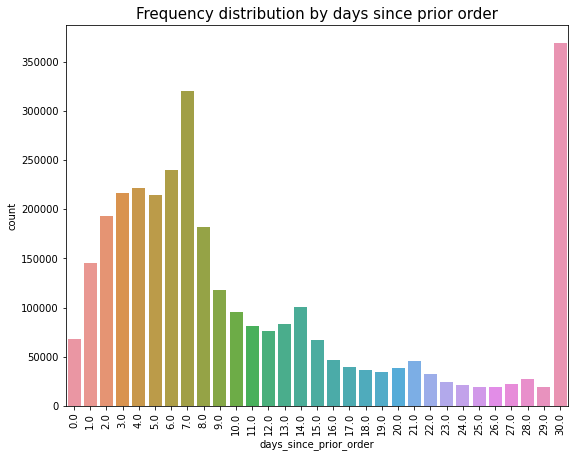

In [ ]:
plt.figure(figsize=(9,7))
sns.countplot(x='days_since_prior_order', data=orders)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

주문 간격이 30일 이상인 케이스가 가장 많고, 대체로 1~8일 간격인 케이스가 많으며 7일 주기(7, 14, 21, 28)로 주문하는 고객도 보인다.

## ✅ 주문별 정보 추가

- 구매 제품 수
- 재구매 제품 비율

In [ ]:
user_order_agg_dict = {'product_id':'count', 
                       'reordered' : 'mean'}

user_order_col = ['items', 'reorder_in_order']

user_orders = df.groupby(['user_id','order_number']).agg(user_order_agg_dict)
user_orders.columns = user_order_col
user_orders.reset_index(inplace=True)
user_orders = user_orders.merge(df.drop_duplicates(['user_id', 'order_number'])[['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 
                                                                   'days_since_prior_order', 'order_id', 'eval_set']], on=['user_id','order_number'], how='left')
user_orders

,user_id,order_number,items,reorder_in_order,order_dow,order_hour_of_day,days_since_prior_order,order_id,eval_set
0,1,1,5,0.000000,2,8,NaN,2539329,prior
1,1,2,6,0.500000,3,7,15.0,2398795,prior
2,1,3,5,0.600000,3,12,21.0,473747,prior
3,1,4,5,1.000000,4,7,29.0,2254736,prior
4,1,5,8,0.625000,4,15,28.0,431534,prior
...,...,...,...,...,...,...,...,...,...
3421078,206209,10,9,0.333333,5,18,29.0,2266710,prior
3421079,206209,11,8,0.750000,4,10,30.0,1854736,prior
3421080,206209,12,20,0.700000,1,12,18.0,626363,prior
3421081,206209,13,9,0.444444,1,12,7.0,2977660,prior


# priors (구매내역)

마지막 주문을 제외한 모든 주문 별로 구매 내역을 확인할 수 있다. 

총 row 수는 32,434,489개다.

- order_id : 주문 번호 (범주형, 명목형)

- product_id : 제품 번호 (범주형, 명목형)

    총 49,677 종의 제품이 있다. (총 팔린 제품이다.)

- add_to_cart_order : 제품이 장바구니에 담긴 순서 (범주형, 순서형)

- reordered : 재구매 여부 (범주형, 명목형)

In [ ]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
prior_df = df[df.eval_set == 'prior']
prior_df.head()

,user_id,order_number,order_id,product_id,product_name,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,aisle,department_id,department,eval_set
0,1,1,2539329,196.0,Soda,1.0,0.0,2,8,NaN,77.0,soft drinks,7.0,beverages,prior
1,1,1,2539329,14084.0,Organic Unsweetened Vanilla Almond Milk,2.0,0.0,2,8,NaN,91.0,soy lactosefree,16.0,dairy eggs,prior
2,1,1,2539329,12427.0,Original Beef Jerky,3.0,0.0,2,8,NaN,23.0,popcorn jerky,19.0,snacks,prior
3,1,1,2539329,26088.0,Aged White Cheddar Popcorn,4.0,0.0,2,8,NaN,23.0,popcorn jerky,19.0,snacks,prior
4,1,1,2539329,26405.0,XL Pick-A-Size Paper Towel Rolls,5.0,0.0,2,8,NaN,54.0,paper goods,17.0,household,prior


## 주문 정보

### 주문 당 구매 제품 수

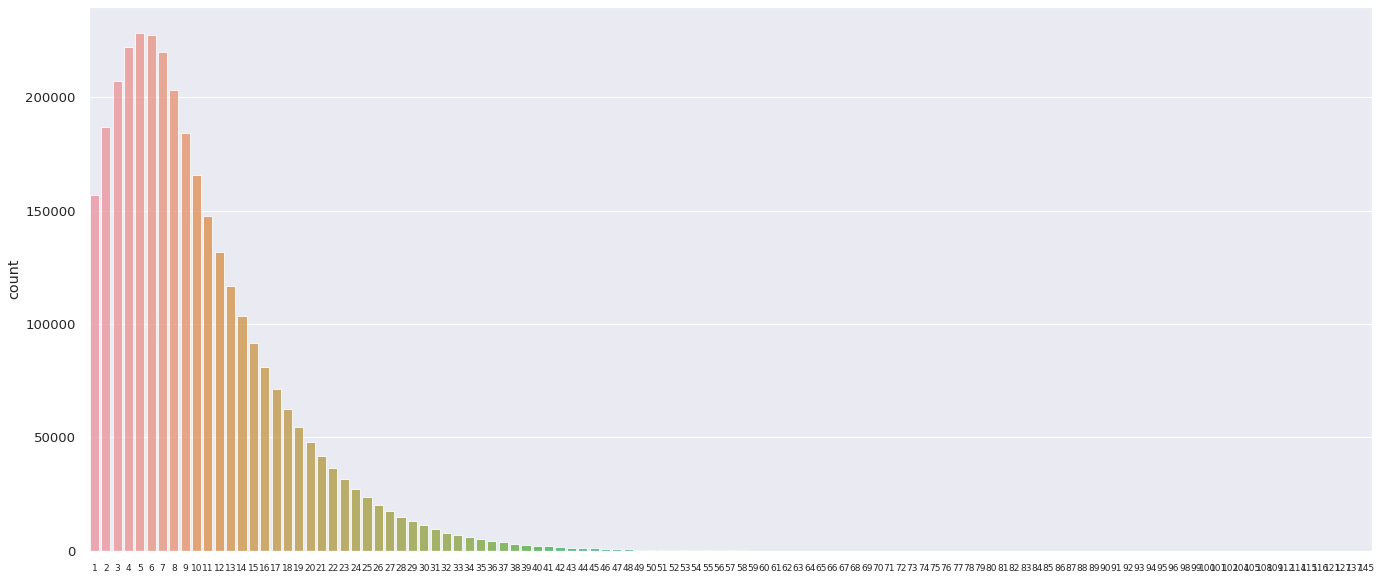

In [ ]:
data = prior_df.groupby('order_id')['add_to_cart_order'].max()
plt.figure(figsize=(23,10))
sns.countplot(data.values.astype(np.uint8), alpha=0.8)
plt.xticks(fontsize=9)
plt.show()

In [ ]:
data.describe().astype(np.uint32)

count    3214874
mean          10
std            7
min            1
25%            5
50%            8
75%           14
max          145
Name: add_to_cart_order, dtype: uint32

주문 당 구매 제품 수는 평균 10개다. 

### 주문 별 재주문 제품 포함 비율


In [ ]:
(prior_df.groupby('order_id')['reordered'].sum() >= 1).astype(np.uint8).value_counts() / prior_df.order_id.nunique()

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [ ]:
# 모든 첫 주문을 뺀 주문 별 재주문 제품 포함 비율 (모든 첫 주문은 재주문 제품이 포함되지 않기 때문)
(prior_df[prior_df.order_number != 1].groupby('order_id')['reordered'].sum() >= 1).astype(np.uint8).value_counts() / prior_df[prior_df.order_number != 1].order_id.nunique()

1    0.939407
0    0.060593
Name: reordered, dtype: float64

전체 order 중 12%는 구매했던 이력이 없는 제품을 구매한 주문이다. 대부분의 고객은 이전에 주문했던 제품을 다시 구매 하는 것으로 보인다.

첫 주문을 제외했을 경우 전체 주문 중 6%만이 재구매 제품이 포함되지 않은 주문이다.

## reordered

### 재구매 여부

In [ ]:
print(f"총 판매 제품 수 : {priors.shape[0]}")
print(f"재구매 제품 수 : {priors.reordered.sum()}")
print(f"재구매 제품 비율 : {(priors.reordered.sum() / priors.shape[0]) * 100:.1f}%")

총 판매 제품 수 : 32434489
재구매 제품 수 : 19126536
재구매 제품 비율 : 59.0%


판매된 모든 제품 중 59%의 제품이 재주문된 제품이다.

## add_to_cart_order

### 장바구니에 담긴 순서 별 재구매 율

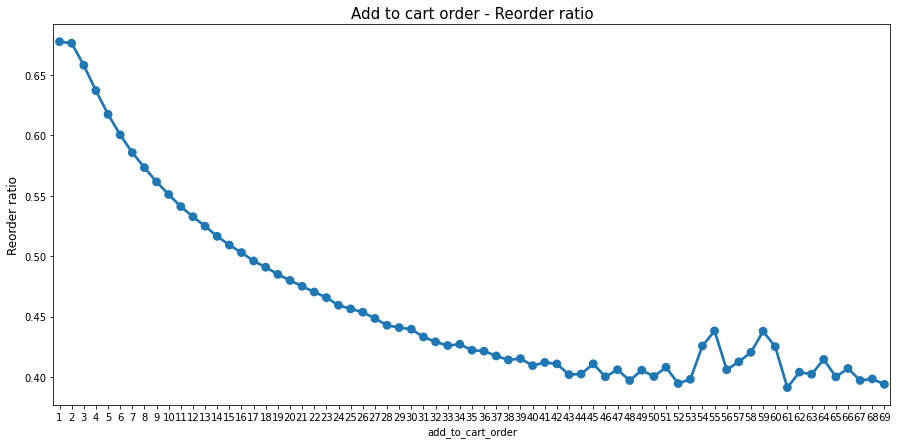

In [ ]:
data = priors[priors['add_to_cart_order'] < 70].groupby('add_to_cart_order')['reordered'].mean()

plt.figure(figsize=(15, 7))
sns.pointplot(data.index, data.values)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.ylabel('Reorder ratio', fontsize=12)
plt.show()

유저가 장바구니에 담은 순서에 따라 재구매율이 큰 영향을 받는 것을 확인할 수 있다. 다시 구매할 제품을 먼저 장바구니에 담는 것으로 보인다.

# ✅ Products




총 49,688개의 row가 있다. 데이터에서 취급하는 모든 제품이다.

EDA를 위해 병합한 데이터에는 팔린 적 없는 3개의 제품을 제외하면 총 49,685개의 제품이 있다. 

제품별로 피쳐를 생성한다.

1. unique_users : 구매한 유저 수
2. total_orders : 총 판매 수
3. total_reorders : 총 재주문 수
4. reorder_rate : 재주문 율
5. avg_cart_order : 평균 장바구니 순위

- 소분류별 피쳐 추가
- 대분류별 피쳐 추가

In [ ]:
agg_dict1 = {'product_id' : 'last', 
             'user_id' : 'nunique',
             'reordered' : ['count','sum','mean'], 
             'add_to_cart_order' : 'mean',
             'aisle' : 'last', 
             'aisle_id' : 'last', 
             'department' : 'last',
             'department_id' : 'last'}
col1 = ['product_id', 'unique_users', 'total_orders', 'total_reorders', 'reorder_rate', 'avg_cart_order', 'aisle','aisle_id','department','department_id']

prod_feats = df.groupby('product_name').agg(agg_dict1)
prod_feats.columns = col1
prod_feats.sort_values(by='total_orders', inplace=True, ascending=False)
prod_feats.reset_index(inplace=True)
prod_feats

,product_name,product_id,unique_users,total_orders,total_reorders,reorder_rate,avg_cart_order,aisle,aisle_id,department,department_id
0,Banana,24852.0,76125,491291,415166.0,0.845051,4.896617,fresh fruits,24.0,produce,4.0
1,Bag of Organic Bananas,13176.0,65655,394930,329275.0,0.833755,5.082916,fresh fruits,24.0,produce,4.0
2,Organic Strawberries,21137.0,61129,275577,214448.0,0.778178,7.279269,fresh fruits,24.0,produce,4.0
3,Organic Baby Spinach,21903.0,56766,251705,194939.0,0.774474,7.431807,packaged vegetables fruits,123.0,produce,4.0
4,Organic Hass Avocado,47209.0,44704,220877,176173.0,0.797607,6.781544,fresh fruits,24.0,produce,4.0
...,...,...,...,...,...,...,...,...,...,...,...
49680,Greek Blended Cherry Fat Free Yogurt,1908.0,1,1,0.0,0.000000,2.000000,yogurt,120.0,dairy eggs,16.0
49681,All Natural Stevia Liquid Extract Sweetener,1002.0,1,1,0.0,0.000000,4.000000,baking ingredients,17.0,pantry,13.0
49682,"Frittata, Farmer's Market",14756.0,1,1,0.0,0.000000,4.000000,frozen appetizers sides,129.0,frozen,1.0
49683,Max White With Polishing Star Soft Toothbrush,26627.0,1,1,0.0,0.000000,14.000000,oral hygiene,20.0,personal care,11.0


- 소분류 & 대분류 정보 추가

In [ ]:
# 소분류 (aisle)
agg_dict2 = {'reordered' : ['count','sum','mean'], 
             'add_to_cart_order' : 'mean'}

col2 = ['aisle_total_orders', 'aisle_total_reorders', 'aisle_reorder_rate', 'aisle_avg_cart_order']

aisle_feats = df.groupby('aisle').agg(agg_dict2)
aisle_feats.columns = col2
aisle_feats.sort_values(by='aisle_total_orders', inplace=True, ascending=False)
aisle_feats.reset_index(inplace=True)
aisle_feats.head()

,aisle,aisle_total_orders,aisle_total_reorders,aisle_reorder_rate,aisle_avg_cart_order
0,fresh fruits,3792661,2726251.0,0.718823,7.155288
1,fresh vegetables,3568630,2123540.0,0.595057,8.873229
2,packaged vegetables fruits,1843806,1178700.0,0.639275,8.417410
3,yogurt,1507583,1034957.0,0.686501,7.874719
4,packaged cheese,1021462,598280.0,0.585710,9.101530


In [ ]:
# 대분류 (department)
agg_dict3 = {'reordered' : ['count','sum','mean'], 
             'add_to_cart_order' : 'mean'}

col3 = ['department_total_orders', 'department_total_reorders', 'department_reorder_rate', 'department_avg_cart_order']

dp_feats = df.groupby('department').agg(agg_dict3)
dp_feats.columns = col3
dp_feats.sort_values(by='department_total_orders', inplace=True, ascending=False)
dp_feats.reset_index(inplace=True)
dp_feats.head()

,department,department_total_orders,department_total_reorders,department_reorder_rate,department_avg_cart_order
0,produce,9888378,6432596.0,0.650521,8.039762
1,dairy eggs,5631067,3773723.0,0.670161,7.510144
2,snacks,3006412,1727075.0,0.574464,9.202543
3,beverages,2804175,1832952.0,0.653651,6.983270
4,frozen,2336858,1268058.0,0.542634,9.015474


In [ ]:
# 병합
prod_feats = prod_feats.merge(aisle_feats, on='aisle', how='left')
prod_feats = prod_feats.merge(dp_feats, on='department', how='left')
prod_feats = prod_feats[
    ['product_name', 'product_id', 'unique_users', 'total_orders', 'total_reorders', 
     'reorder_rate', 'avg_cart_order', 
     'aisle', 'aisle_id', 'aisle_total_orders', 'aisle_total_reorders', 
     'aisle_reorder_rate', 'aisle_avg_cart_order', 
     'department', 'department_id', 'department_total_orders', 'department_total_reorders', 
     'department_reorder_rate', 'department_avg_cart_order']
]
prod_feats.head()

,product_name,product_id,unique_users,total_orders,total_reorders,reorder_rate,avg_cart_order,aisle,aisle_id,aisle_total_orders,aisle_total_reorders,aisle_reorder_rate,aisle_avg_cart_order,department,department_id,department_total_orders,department_total_reorders,department_reorder_rate,department_avg_cart_order
0,Banana,24852.0,76125,491291,415166.0,0.845051,4.896617,fresh fruits,24.0,3792661,2726251.0,0.718823,7.155288,produce,4.0,9888378,6432596.0,0.650521,8.039762
1,Bag of Organic Bananas,13176.0,65655,394930,329275.0,0.833755,5.082916,fresh fruits,24.0,3792661,2726251.0,0.718823,7.155288,produce,4.0,9888378,6432596.0,0.650521,8.039762
2,Organic Strawberries,21137.0,61129,275577,214448.0,0.778178,7.279269,fresh fruits,24.0,3792661,2726251.0,0.718823,7.155288,produce,4.0,9888378,6432596.0,0.650521,8.039762
3,Organic Baby Spinach,21903.0,56766,251705,194939.0,0.774474,7.431807,packaged vegetables fruits,123.0,1843806,1178700.0,0.639275,8.417410,produce,4.0,9888378,6432596.0,0.650521,8.039762
4,Organic Hass Avocado,47209.0,44704,220877,176173.0,0.797607,6.781544,fresh fruits,24.0,3792661,2726251.0,0.718823,7.155288,produce,4.0,9888378,6432596.0,0.650521,8.039762


## 분석




1. product
- 판매수와 재구매수
- 판매량과 재구매율
2. aisle
- 판매수와 재구매수
3. department
- 판매수와 재구매수

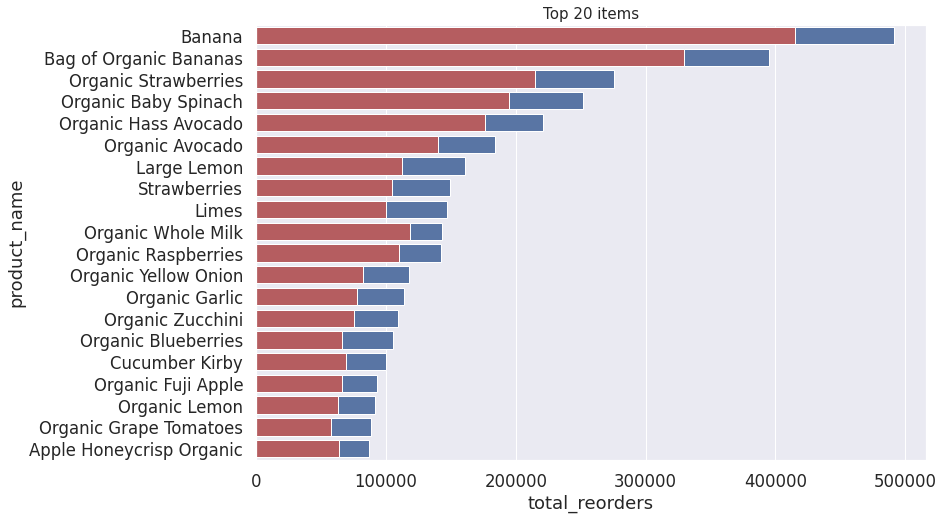

In [ ]:
# 가장 많이 팔린 제품 Top20
plt.figure(figsize=(12, 8))
plt.title('Top 20 items', fontsize=15)
sns.barplot(prod_feats.total_orders.astype(np.object0)[0:20], prod_feats.product_name.astype(np.object0)[0:20], label='total', color=color[0])
sns.barplot(prod_feats.total_reorders.astype(np.object0)[0:20], prod_feats.product_name.astype(np.object0)[0:20], label='reorders', color=color[3])
plt.show()

 Top20 제품의 대부분이 과일, 채소 등 신선식품이며 판매량 1,2위 모두 바나나로 가장 많이 팔렸다. Oragnic 제품이 상위권에 많이 분포한 것을 알 수 있다.

count     49685.000000
mean        680.670343
std        4987.769425
min           1.000000
25%          18.000000
50%          63.000000
75%         272.000000
max      491291.000000
Name: total_orders, dtype: float64


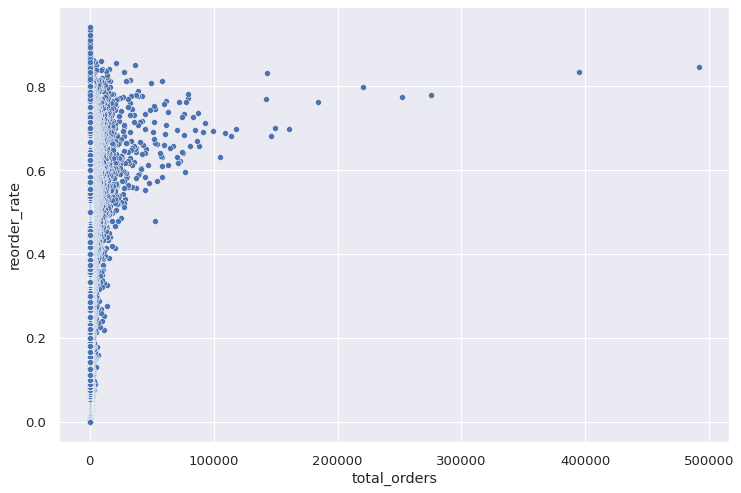

In [ ]:
# 제품별 판매량과 재구매율
print(prod_feats.total_orders.describe())

plt.figure(figsize=(12, 8))
sns.scatterplot(x='total_orders', y='reorder_rate', data=prod_feats)
plt.show()

판매량이 높은 제품은 재구매율도 높게 나타난다.

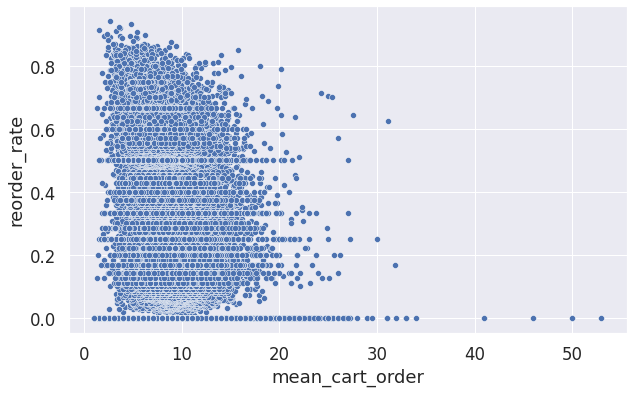

In [ ]:
# 장바구니 순위와 재구매율
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_cart_order', y='reorder_rate', data=prod_feats)
plt.show()

- aisle

재주문율 상위 20

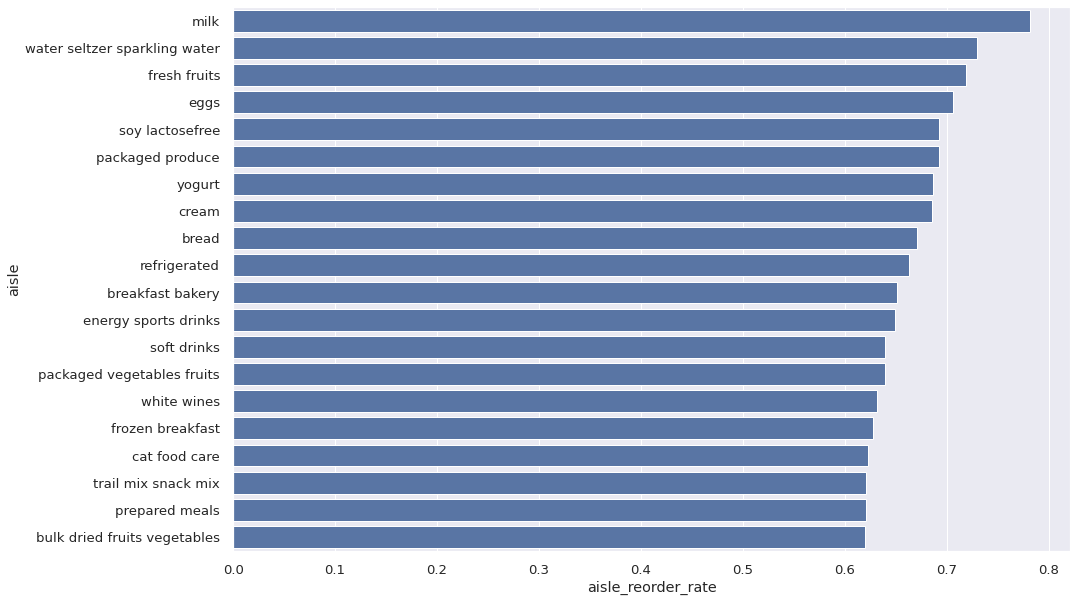

In [ ]:
aisle_feats = aisle_feats.sort_values('aisle_reorder_rate', ascending=False, ignore_index=True)

plt.figure(figsize=(15,10))
sns.barplot(y=aisle_feats.aisle.astype(np.object0)[:20], x=aisle_feats.aisle_reorder_rate[:20], color=color[0])
plt.show()

우유, 과일, 달걀 등 자주 소비하는 품목들을 확인할 수 있다.

재주문율 하위 20

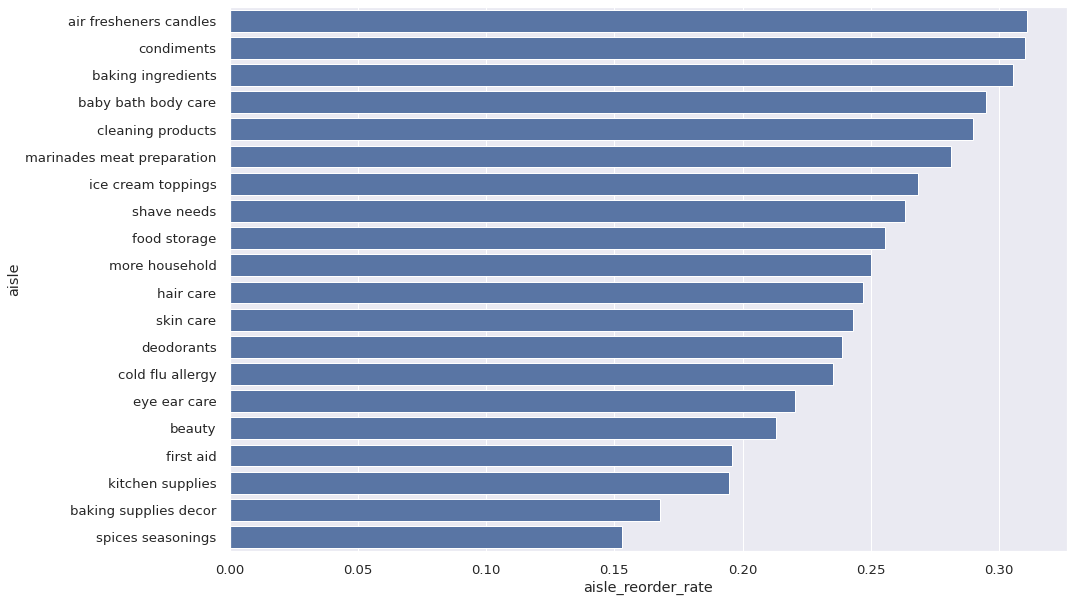

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(y=aisle_feats.aisle.astype(np.object0)[-20:], x=aisle_feats.aisle_reorder_rate[-20:], color=color[0])
plt.show()

자주 사용하는 식품류 보다는 시즈닝, 주방 용품, 스킨케어 제품처럼 사놓고 쓰는 제품들이 많은 것을 볼 수 있다.

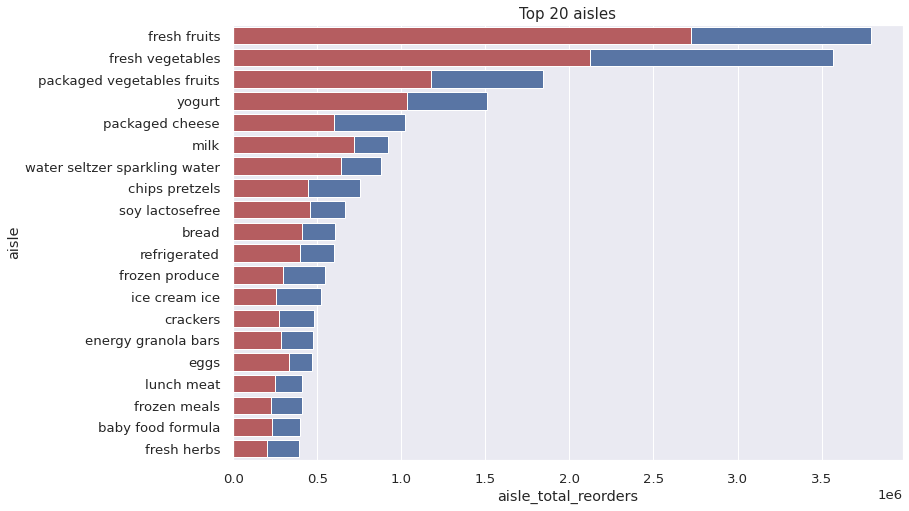

In [ ]:
# aisle 주문수와 재주문 수 Top 20 
aisle_feats = aisle_feats.sort_values('aisle_total_orders', ascending=False, ignore_index=True)

plt.figure(figsize=(12, 8))
plt.title('Top 20 aisles', fontsize=15)
sns.barplot(aisle_feats.aisle_total_orders[0:20], aisle_feats.aisle.astype(np.object0)[0:20], label='total', color=color[0])
sns.barplot(aisle_feats.aisle_total_reorders[0:20], aisle_feats.aisle.astype(np.object0)[0:20], label='reorders', color=color[3])
plt.show()

- department

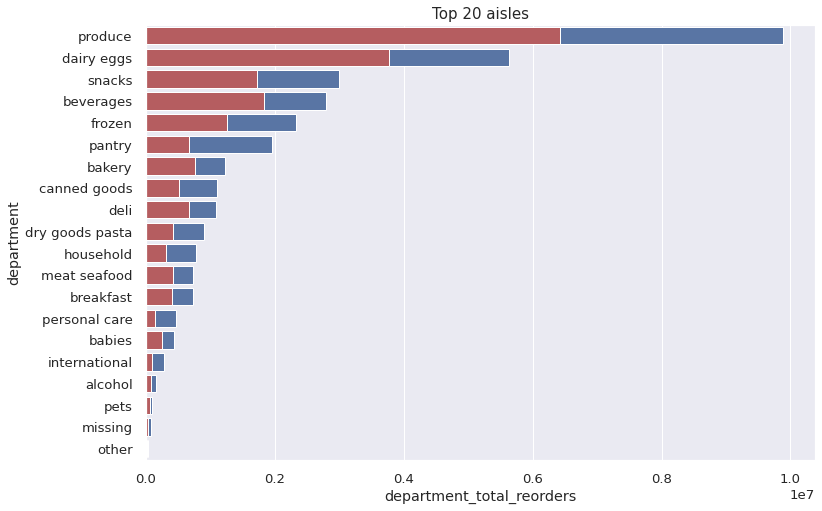

In [ ]:
# department 주문수와 재주문 수 Top 20 
dp_feats = dp_feats.sort_values('department_total_orders', ascending=False, ignore_index=True)

plt.figure(figsize=(12, 8))
plt.title('Top 20 aisles', fontsize=15)
sns.barplot(dp_feats.department_total_orders[0:20], dp_feats.department.astype(np.object0)[0:20], label='total', color=color[0])
sns.barplot(dp_feats.department_total_reorders[0:20], dp_feats.department.astype(np.object0)[0:20], label='reorders', color=color[3])
plt.show()

# ✅ users 유저별

유저별 피쳐 생성

총 206,209 rows : 총 유저 인원 수와 같다. 

- 총 주문 수
- 총 구매 제품 수
- 총 구매 제품 종류 수
- 재구매 제품 수
- 재구매 제품 비율
- 주문당 평균 구매 제품 수
- 주문당 평균 재구매 제품 비율


주문 요일, 시간, 재주문 기간에 따른 구매 제품의 변화?

In [ ]:
user_agg_dict2 = {'order_number' : 'max', 
             'product_id' : ['count', 'nunique'], 
             'reordered' : ['sum', 'mean']}
user_col2 = ['total_orders', 'total_products', 'unique_products', 'total_reorders', 'reorder_rate']

users = df.dropna(subset=['product_id']).groupby('user_id').agg(user_agg_dict2) # product_id가 결측치인 행은 제거 (테스트 셋인 7.5만명의 마지막 주문 삭제)
users.columns = user_col2
users.reset_index(inplace=True)
users['avg_items_in_order'] = user_orders.groupby('user_id')['items'].mean().values
users['avg_reorder_in_order'] = user_orders[user_orders['order_number'] != 1].groupby('user_id')['reorder_in_order'].mean().values
users

,user_id,total_orders,total_products,unique_products,total_reorders,reorder_rate,avg_items_in_order,avg_reorder_in_order
0,1,11,70,19,51.0,0.728571,6.363636,0.796742
1,2,15,226,121,105.0,0.464602,15.066667,0.475611
2,3,12,88,33,55.0,0.625000,6.769231,0.718710
3,4,5,18,17,1.0,0.055556,3.000000,0.035714
4,5,5,46,28,18.0,0.391304,9.200000,0.488889
...,...,...,...,...,...,...,...,...
206204,206205,4,51,37,14.0,0.274510,12.750000,0.474311
206205,206206,67,285,150,135.0,0.473684,4.191176,0.579323
206206,206207,16,223,92,131.0,0.587444,13.117647,0.679620
206207,206208,49,677,198,479.0,0.707533,13.540000,0.714959


## 분석

In [ ]:
users[users.avg_reorder_in_order == 1].sort_values('total_orders', ascending=False, ignore_index=True)

,user_id,total_orders,total_products,unique_products,total_reorders,reorder_rate,avg_items_in_order,avg_reorder_in_order
0,99753,100,193,2,191.0,0.989637,1.930000,1.0
1,170174,48,48,1,47.0,0.979167,1.000000,1.0
2,37075,37,37,1,36.0,0.972973,1.000000,1.0
3,110225,36,60,2,58.0,0.966667,1.666667,1.0
4,190455,31,59,3,56.0,0.949153,1.843750,1.0
...,...,...,...,...,...,...,...,...
680,75819,3,8,4,4.0,0.500000,2.000000,1.0
681,75361,3,5,2,3.0,0.600000,1.250000,1.0
682,163118,3,3,1,2.0,0.666667,0.750000,1.0
683,163195,3,8,3,5.0,0.625000,2.000000,1.0


총 685명의 유저는 처음 구매한 제품만 계속 구매했다.

유저 99753는 총 100번 주문하는 동안 단 2가지 제품만 계속 구매했다.

# User_produtcs_priors 





유저별로 해당 유저가 구매한 모든 제품을 1:1로 매칭 시켜서 새로운 데이터를 생성한다.

- total_orders : 총 구매수
- total_reorders : 총 재구매 수
- reorder_rate : 재구매율
- first_order_num : 첫 주문 순서
- last_order_num : 마지막 주문 순서
- sum_cart_order : 장바구니 순위 합
- avg_cart_order : 평균 장바구니 우선순위


In [ ]:
user_prod_agg_dict = {'reordered':['count', 'sum', 'mean'], 
                  'order_number':['min', 'last'], 
                  'add_to_cart_order' : ['sum', 'mean']}

user_prod_col = ['total_orders', 'total_reorders', 'reorder_rate', 'first_order_num', 'last_order_num', 'sum_cart_order', 'avg_cart_order']

user_prods = df[(df.eval_set == 'prior')].groupby(['user_id', 'product_id']).agg(user_prod_agg_dict)
user_prods.columns = user_prod_col
user_prods.reset_index(inplace=True)
user_prods = user_prods.merge(df[(df.eval_set == 'prior')].drop_duplicates('product_id')[['product_id', 'product_name', 'aisle', 'department']], on='product_id', how='left')
print(user_prods.shape)
user_prods.head()

(13307953, 12)


,user_id,product_id,total_orders,total_reorders,reorder_rate,first_order_num,last_order_num,sum_cart_order,avg_cart_order,product_name,aisle,department
0,1,196.0,10,9.0,0.900000,1,10,14.0,1.400000,Soda,soft drinks,beverages
1,1,10258.0,9,8.0,0.888889,2,10,30.0,3.333333,Pistachios,nuts seeds dried fruit,snacks
2,1,10326.0,1,0.0,0.000000,5,5,5.0,5.000000,Organic Fuji Apples,fresh fruits,produce
3,1,12427.0,10,9.0,0.900000,1,10,33.0,3.300000,Original Beef Jerky,popcorn jerky,snacks
4,1,13032.0,3,2.0,0.666667,2,10,19.0,6.333333,Cinnamon Toast Crunch,cereal,breakfast


# ✅ train 유저 구매 내역

train셋에 있는 유저들의 구매내역으로 데이터를 재구성한다. 

train셋의 유저들은 마지막 주문내역이 있기 때문에 제품별로 재구매 여부를 파악할 수 있다.

In [ ]:
# 1. train 셋 유저 명단 뽑기 
train_users = df[df.eval_set == 'train'].user_id.unique() 

# 2. eval_set이 priors에서 train 셋 유저만 가져오기. train셋 유저의 모든 구매내역
train_priors = df[(df.eval_set == 'prior') &  (df.user_id.isin(train_users))]

In [ ]:
# 3. 유저, 제품으로 묶기 (제품 정보도 추가)
train_user_prod_agg_dict = {'reordered':['count', 'sum', 'mean'], 
                  'order_number':['min', 'last'], 
                  'add_to_cart_order' : ['sum', 'mean']}

train_user_prod_col = ['total_orders', 'total_reorders', 'reorder_rate', 'first_order_num', 'last_order_num', 'sum_cart_order', 'mean_cart_order']

train_priors_prods = train_priors.groupby(['user_id', 'product_id']).agg(train_user_prod_agg_dict)
train_priors_prods.columns = train_user_prod_col
train_priors_prods.reset_index(inplace=True)
train_priors_prods = train_priors_prods.merge(train_priors.drop_duplicates('product_id')[['product_id', 'product_name', 'aisle', 'department']], on='product_id', how='left')
# train_priors_prods

In [ ]:
# 4. reordered 뽑아서 병합
# 마지막 주문에서 해당 제품을 구매했는지 안 했는지 알 수 있다. 
train_priors_prods = train_priors_prods.merge(df[df.eval_set == 'train'][['user_id','product_id','reordered']], on=['user_id','product_id'], how='left') 
train_priors_prods['reordered'].fillna(0, inplace=True)
train_priors_prods = train_priors_prods[['user_id', 'product_name', 'reordered', 'total_orders', 'total_reorders', 'reorder_rate', 'first_order_num', 'last_order_num', 
 'sum_cart_order', 'mean_cart_order','product_id',  'aisle', 'department']]
train_priors_prods.sort_values(by=['user_id', 'total_orders'], ascending=[True, False], inplace=True, ignore_index=True)
train_priors_prods = train_priors_prods.astype({'total_orders' : np.uint8, 'product_id' : np.float32})
print(train_priors_prods.shape)
train_priors_prods.head()

(8474661, 13)


,user_id,product_name,reordered,total_orders,total_reorders,reorder_rate,first_order_num,last_order_num,sum_cart_order,mean_cart_order,product_id,aisle,department
0,1,Soda,1.0,10,9.0,0.900000,1,10,14.0,1.400000,196.0,soft drinks,beverages
1,1,Original Beef Jerky,0.0,10,9.0,0.900000,1,10,33.0,3.300000,12427.0,popcorn jerky,snacks
2,1,Pistachios,1.0,9,8.0,0.888889,2,10,30.0,3.333333,10258.0,nuts seeds dried fruit,snacks
3,1,Organic String Cheese,1.0,8,7.0,0.875000,3,10,32.0,4.000000,25133.0,packaged cheese,dairy eggs
4,1,Cinnamon Toast Crunch,1.0,3,2.0,0.666667,2,10,19.0,6.333333,13032.0,cereal,breakfast


### 분석

- 타겟 분포

0.0    7645837
1.0     828824
Name: reordered, dtype: int64


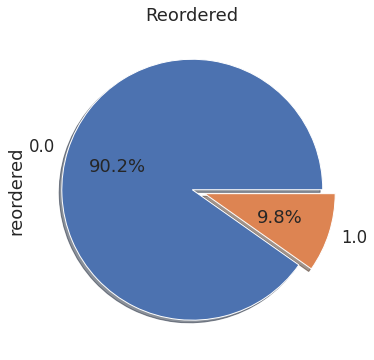

In [ ]:
print(train_priors_prods.reordered.value_counts())

plt.figure(figsize=(8, 6))
train_priors_prods.reordered.value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True)
plt.title('Reordered')
plt.show()

전체 구매한 제품 중 마지막 주문에서 재구매한 제품은 9.8%다.

# 3. ✅ 아웃풋을 만들진 못했지만 진행 중인 가설들
    1. 유저의 재구매에 영향을 주는 요소 찾아보기
        1. order_number(구매횟수)가 높은 주문일수록 재구매율이 높을 것이다
        2. days_since_prior_order가 짧은 주문일수록 재구매율이 높을 것이다
    2. 고객들은 각각의 구매패턴을 가지고 있고 구매패턴에 따라 유형화 할 수 있을 것이다.
        1. 재구매제품 별 구매패턴 - 제품 중 재구매비율이 높은 특정 제품들이 있고 이 제품들을 구매하는 유저들의 구매패턴은 비슷할 것이다
        2. 장바구니 선호제품 별 구매패턴 - 장바구니에 특정 제품을 먼저 담는 유저들의 구매패턴은 비슷할 것이다
        3. 구매주기 별 구매패턴 - 구매주기에 따라 구매하는 제품이 다를 것이다
        4. 구매수량 별 구매패턴 - 한번의 order에 제품을 구매하는 수량에 따라 구매패턴이 다를 것이다
        5. 구매요일 & 시간별 구매패턴 - 특정 요일 및 시간대에 발생하는 오더에 따라 구매제품이 다를 것이다